# Interpreting Video Classification Models 
William Song, Thomas Li, David Vendrow, Forest Hu

A major deficiency of deep learning models is their inability to provide insight into the actual features learned. Indeed, after training, these models are typically used as nothing more than “black boxes.” From a research perspective, this approach limits our intuition for and understanding of the effectiveness of deep models. From an engineering perspective, developers risk deploying models that perform well in a controlled training environment but are actually fragile in the real world.

In recent years, researchers have developed many techniques for providing some level of interpretability of the parameters and performance of deep models. One popular technique is visualization by optimization. As Professor Listgarten mentioned in lecture, this technique went viral in mainstream media in 2015 under the name “Google Deep Dream.” In short, visualization by optimization allows us to generate images by performing gradient ascent on an input image toward a target class (we formalize the optimization problem in a later section). These visualizations allow engineers and researchers to investigate whether the model has actually learned reasonable features of an object class. Below is a famous example of this technique in action from Google’s Research Blog [5].

<img src="./images/deepdream_example1.png">
<figcaption><center>From Google’s Research Blog [5]</center></figcaption>

We can see that the model has captured the “essence” of the classes above to a reasonable degree. However, when the team at Google visualized “dumbbells,” they saw some unexpected results: 

<img src="./images/deepdream_example2.png">
<figcaption><center>From Google’s Research Blog [5]</center></figcaption>

From the visualizations, we see that the model has learned that dumbbells are always accompanied by a person holding or lifting them rather than just the dumbbell itself. This insight reveals that the model was likely trained only on dumbbells being lifted by people rather than dumbbells alone, demonstrating how one can use visualizations to catch faulty models. 

Another commonly used technique is creating saliency maps. These maps provide a visualization of the “impact” of each individual pixel on the final classification score. With this technique, engineers and researchers can gain insight on specific parts of an input that resulted in the classification. 

<img src="./images/saliency_example1.png">
<figcaption><center>From Visualising Image Classification Models and Saliency Maps [2]</center></figcaption>


In the image above, the brightness of each pixel is proportional to its “impact”. For example, we see that pixels with water are actually important when classifying a “sailboat.” While this could potentially be desired behavior (boats are typically in water), it also suggests that the model is weak at classifying boats that are out of water. For any service that utilizes machine learning, the capability to explain why a model made a particular decision on a particular input is vital. Later on, we will elaborate on the details on of how these maps are generated.

**The goal of our project is to explore how these visualization techniques generalize to videos**. While all of these techniques have been thoroughly explored and developed with static image data, to our knowledge there are no published examples of these techniques performed on video data. Video data presents a set of new challenges that we attempt to overcome in this project. How much more computational power will we need? Will there be continuity between frames? How can we visualize an "action?" **Since the results are subjective and qualitative in nature, our project will be a “tutorial-like” walkthrough of the different regularization techniques we implemented and the corresponding results** (as opposed to a typical paper with accuracy measurements and graphs). We document each technique we use and provide sample GIFs of the outcomes.


# I3D Models and The Kinetics Dataset

The Kinetics dataset was created by the Google DeepMind team in 2017 to provide a way of training machine learning models made for video and action analysis and classification [6]. The Kinetics dataset contains 400 different classes with at least 400 different videos for each class broken up into approximately 250 videos for training, 100 videos for testing, and 50 videos for validation. The dataset primarily focuses on human action and is split into several classes with further hierarchical structure. The Person-Person class primarily focuses on interactions between groups of people, the Person class focuses on actions performed by a single person, and the Person-Object class captures human-object interaction. Within these classes, the Kinetics dataset is further split into parent-child classes. Each parent class has a label that groups its child classes together by similarity. An example is the cloths class with the following child classes: bandaging, doing laundry, folding clothes, folding napkins, ironing, making bed, tying bow tie, tying knot (not on a tie), tying tie.

<img src="./images/juggling_soccerball.gif">
<figcaption><center>Training Example Of "Juggling Soccer Ball"</center></figcaption>

The kinetics dataset deals with the large issue of bias towards its actions [5]. The classification problem bias essentially splits itself into two categories: action bias and object bias. We define object bias as bias towards certain objects present in the training set for a feature, and we define action bias as bias towards a specific movement pattern in the training set for a feature. Objects provide a large crutch during action recognition for neural nets. In the kinetics dataset, certain classes exist with large object bias.

Later on, we will see how this bias is revealed through our visualizations.

For certain classes, the action classification problem reduces to an image classification problem over multiple frames. For example, classifying between the actions “playing cello”, “playing flute”, and “playing trumpet” is primarily a matter of discriminating between the instruments. This can be done with a single static frame from the video, and it doesn't rely on the relationship between frames. In our project, we attempted to stray away from these types of actions and focus on classes that required significant information from the temporal domain. For example, discriminating between "swimming backstroke”, “swimming breaststroke”, and “swimming butterfly” requires analyzing the specific movements, which occur over multiple frames.

There have been several alternate approaches in the past that have attempted video classification. The preeminent approach simply took existing convolutional neural net architecture and applied it to video. Since the convolutional neural network only operates on images, the method of applying it involved stringing sequences of images together with an LSTM. Unfortunately, this approach failed to capture the temporal aspect of video.

<img src="./images/I3D.png" width="200"/>
<figcaption><center>Diagram of I3D [10]</center></figcaption>

<table border="0">
<tr>
<tr>
<td align="center" valign="center">
<img src="./images/v_CricketShot_g04_c01_rgb.gif"/>
<figcaption><center>Example RGB channel input (playing cricket)[9]</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/v_CricketShot_g04_c01_flow.gif"/>
<figcaption><center>Example Optical Flow channel input (playing cricket)[9]</center></figcaption>
</td>
</tr>
</table>

In this project, we chose to implement the Inflated 3D ConvNet (or I3D, for short - diagrammed above), trained on the Kinetics dataset [10]. This neural net model differs from others in several ways. It begins by training two separate neural nets: an RGB 3D ConvNet, and an Optical Flow Net. To make a prediction, the model simply averages the results from both models. The motivation behind the two nets is that the 3D ConvNet captures RGB data well but does not explicitly capture the temporal aspect of videos. On the other hand, optical flow nets are inherently recurrent in nature which might aid in capturing the expression of temporal aspects of video.

# Saliency Maps
Saliency maps are a great tool for visualizing the impact of individual pixels on the final classification score outputted by the model. Before the final softmax layer, the model produces unnormalized logits for each class. We compute the gradient of the true class with respect to each individual pixel, and then visualize the magnitudes as a saliency map. Specifically, we first compute the absolute value of the gradient of each pixel in the input video. Then, we take the max across all 3 RGB color channels. We did not compute saliency maps of Optical Flow inputs as the inputs themselves already strongly resemble saliency maps. 

In the visualization of the saliency maps, we shade pixels brighter if they have high gradients and darker if they have low gradients. We constructed saliency maps for videos taken from the kinetics dataset in the specified time frame provided. Instead of taking the gradient with respect to an image, we tuned the original saliency map technique [8] for images to video by adding another dimension to our tensor, producing moving saliency map videos. 

<table border="0">
<tr></tr>
<tr>
<td align="center" valign="center">
<img src="./images/backstroke_saliency.gif">
<figcaption><center>Swimmming Backstroke</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/juggling_saliency.gif">
<figcaption><center>Juggling Soccer Ball</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/butterfly_saliency.gif">
<figcaption><center>Swimming Butterfly Stroke</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/kicking_saliency.gif">
<figcaption><center>Kicking Soccer Ball</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/breast_saliency.gif">
<figcaption><center>Swimming Breast Stroke</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/eating_watermelon_saliency.gif">
<figcaption><center>Eating Watermelon</center></figcaption>
</td>
</tr>
</table>

* In the backstroke saliency map, we notice that with the arm underwater, the model finds it hard to detect activity and remains dark. However, once the arm breaks the surface, the saliency map jumps in activity. Water doesn’t seem to be a large trigger point for backstroke, but rather the motion of the arms and position of the head and torso. 

* In butterfly, the dead giveaway seems to be the sweeping motion of the arms. When the swimmer breaks the surface, We can see in the saliency map the extremely high activation rates of the pixels corresponding to head, torso, and arm movements. This makes sense in line with the backstroke saliency map as after the swimmer breaks the surface and returns into an underwater streamlined position, the neural net seems to rest once more. 

* In the breaststroke video, The saliency map seems to respond extremely positively to the breaststroker once again after he emerges from the surface. It returns to lower levels once the breaststroker goes into underwater streamline. This also matches up with the butterfly and breaststroke saliency maps. 

* In the juggling soccer ball video, one of the main keys that the class looks for are signs of a soccer/football field. They track the yard lines very carefully and seem to respond better to the lines than to the person juggling the ball. However we can still see that the arms and legs provide lots of information, moreso than the head and torso as these limbs give more information in regards to movement patterns than the torso and head which stay in place. 

* In kicking soccer balls, we see high activation rates once again with lines across a field. The cones trace the line and activate the neurons heavily. We note that the actual ball seems to have somewhat low activation rates once the first soccer player exits the frame of view. Once the second soccer player enters however, the ball seems to regain activation energy once again. We note that the limbs of the soccer players have very high activation energy. 

* In the watermelon video, we note that the watermelon and the boy’s hand seem to have the highest activation energy. The motion doesn’t seem to matter as much in this video as the activation energy closely follows the watermelon slice. 

Reader - please notice the following two things. In most of these videos, the network is very responsive to humans. This aligns with the fact that all the kinetics training videos exhibit people performing actions. Hence, it would make sense that the network is sensitive to areas containing humans. The second is that object consistency plays an important role in the neural network’s ability to identify objects. We hypothesize that the more standardized an object is, the easier it is for the neural network to classify it.

# Visualization by Optimization
To visualize a class, we start with a random noise video input and then perform gradient ascent toward a target class. However, naively attempting this will result in adversarial inputs [4]. One must employ several regularization techniques to generate videos that resemble the desired class. Problems that we anticipated with video visulization were computational intensity, continuity between frames, and succesful "motion visualization." On the point of "motion visualization," we suspect that many visualizations will simply reveal objects that are tightly related to the action class rather than any perceivable motion.

We formalize the problem in a similiar fashion as [3]. Without loss of generailty, let us consider only the RBG input (the optical flow formalization only differs from RGB in dimension values). Let $x \in R^{NxHxWxC}$ be a RGB video where $N$ is the number of frames, $H$ and $W$ are the height and width respectively, and $C$ is the number of the color channels. For the i3d model, $H=W=224$, $C=3$, and $N=25$. The number of frames can be arbitrarily long or short for visualization, but we chose 25 as that is the frame input length at test time for the I3D model. A large $N$ can result in high computation costs, while a small $N$ results in visualizations that are limited in expressing motion. 

Now, let $y$ be the target class. Let $s_y(x)$ be the logits (scores before the final softmax layer) that the i3d model assigns to the image $x$ for class $y$. Our goal we can now frame our objective as the folowing optimization problem:

$$
x^* = \arg\max_x s_y(x) - R_\theta(x)
$$

where $R_\theta$ is a paramaterized regularization function that regularizes images both explicitly and implicitly. Since the regularizer function can be very complex (as described below) and no closed-form solution exists, we resort to solving this optimization problem with gradient ascent. We compute gradients of $s_y(x)$ with respect to the generated video $x$. 

Our primary explicit regualization is L2 regularization of the form 

$$
R_\theta(x) = \lambda \|x\|_2^2
$$ 

and our primary implicit regularization (as implemented in [3]) is performed by periodically blurring the generated image with a gaussian filter. These two intial regularizing operations were good enough to create baseline results (as we will see), but additional operations are also used and listed below:
1. Jitter - randomly displace pixels up to $\theta$ pixels away between iterations
2. Scale - scale the video and then crop to the original dimensions after $\theta$ iterations
3. Time blur - gaussian blur across frames
4. Clipping - clip pixels that fall out of a certain range

# Regualization Techniques for Optimization
This section will walk through the effect of the different regularization techniques we employed and their effect on generated images.

Each visualization is a GIF with 25 frames. All of the following visualizations were produced on an Nvidia GeForce GTX 1080.  Running 1000 iterations of feature optimizations takes about 330 seconds on a 1080. Unfortunately, we found these visualizations are nearly intractable on a CPU. With a  3.1 GHz Intel Core i5, one iteration already takes about 60 seconds. If one wants to run 1000 iterations that will be a runtime of $\frac{1000 * 65}{60*60} = 18.1$ hours! For comparison, optimizing an image (such as in Deep Dream) takes about 15 minutes on GoogLeNet [7]. We recommend anyone who wants to attempt these visualizations to use a GPU. 
 
We initialize a random noise video where every pixel is independently sampled from a uniform distribution $U[0,1]$. First we implemented a regularizer function with  L2-Regularization, Gaussian Blurring and Jittering. Surprisingly, with just these techniques, the results already began to resemble the target action class. Can you guess what the class below resembles? Hint: Do you see hands?

<img src="./images/arm_wrestle_discontinous.gif">

The class is “arm wrestling.” As anticipated, the video drastically shifts between frames. However, the “form” of the several hands clasped together does seem to persist across frames. Mainly, the wild fluctuation of colors seem to be the main cause of creating discontinuity. To mitigate this, we first changed our noise initialization so that every frame had the same starting point. Specifically, we randomly initialized one frame in the same manner as before, but we then inflated that single frame to be $N=25$ frames so that each frame has the same starting seed. Unfortunately, this produced no perceivable difference. Afterward we attempted “time blurring,” where periodically use a gaussian blur across frames to mimic “motion blur” and to better promote time continuity. 

<img src="./images/arm_wrestling_smooth.gif">
<figcaption><center>Arm Wrestling</center></figcaption>

Now, we see that “arm wrestling” has a much smoother transition between frames. However, we can still observe any reasonable amount of “motion.” However, it seems more like objects “dissolving” in and out of the noise rather than true movement. At this point, we visualized many other classes in an attempt so see if we can find a visualization that properly captures motion.

<table border="0">
<tr></tr>
<tr>
<td align="center" valign="center">
<img src="./images/archery-Copy1.gif">
<figcaption><center>Archery</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/dribbling_basketball-Copy1.gif">
<figcaption><center>Dribbling Basketball</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/eating_watermelon1000_iterations-Copy1.gif">
<figcaption><center>Eating Watermelon</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/playing_cello-Copy1.gif">
<figcaption><center>Playing Cello</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/juggling_soccer_ball-Copy1.gif">
<figcaption><center>Juggling Soccer Ball</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/kicking_soccer_ball-Copy1.gif">
<figcaption><center>Kicking Soccer Ball</center></figcaption>
</td>
</tr>

</table>

Unfortunately, it seems that all our visualizations seems to only create objects that “dissolve” in and out of the frames. In “archery” one can see a bow as well as targets fade in and out. For “eating watermelon” one only sees static watermelons scattered around the GIF. In "dribbling basketball" we only see basketballs and rims. We chose the bottom two action classes, “kicking soccer ball” and “juggling soccer ball”, specifically because they can only be differentiated by their motion rather than solely by their objects. Yet, we see no perceivable difference “in action” between the two visualizations; only soccer balls appear with some stray legs and feet. 

At this point, we notice that the GIFs appear to be dark (lots of regions of black) and also seem to have some concentrated white spots scattered around. RGB values take on a value of [0, 1], where 0 corresponds to 0% intensity and 1 corresponds to 100% intensity. A tuple of (1, 1, 1) results in a white pixel while a tuple of (0, 0, 0) results in a black pixel. When we investigated the RGB values of our generated images, we found that many of the pixels had negative RGB values or had RGB values greater than one. These would then be clipped when visualized as a GIF (negative values go to 0 and values greater than 1 go to one). Thus, many iterations were wasted on producing unperceivable changes and much of the gradients were concentrated on pixels that were already well out of the RGB range. To fix this, we simply made sure to clip our generated input at every iteration so that we never exceed the [0,1] range.

<table border="0">
<tr></tr>
<tr>
<td align="center" valign="center">
<img src="./images/archery_rgb-Copy1.gif">
<figcaption><center>Archery</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/arm_wrestling_rgb-Copy1.gif">
<figcaption><center>Arm Wrestling</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/swimming_breast_stroke_rgb.gif">
<figcaption><center>Swimming Breast Stroke</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/swimming_butterfly_stroke_rgb.gif">
<figcaption><center>Swimming Butterfly Stroke</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/juggling_soccer_ball_rgb-Copy1.gif">
<figcaption><center>Juggling Soccer Ball</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/kicking_soccer_ball_rgb-Copy1.gif">
<figcaption><center>Kicking Soccer Ball</center></figcaption>
</td>
</tr>
</table>

Now, we can finally see some motion in some visualizations. With “juggling soccer ball,” in the top right corner we see the ball actually move up and down with a human-like figure behind it. In “kicking soccer ball,” we can see a human approach the ball from the side. In “swimming butterfly stroke,” we see arms raise upwards in the butterfly formation. In “swimming breast stroke,” we see arms out to the sides, heads raising upward “out of the water,” and then finally dipping downward at the end.

Lastly, we present a few other techniques we attempted that did not give significantly better results. One can potentially tune and explore the hyperparameters to give better results. We also attempted to visualize Optical Flow. 

<table border="0">
<tr></tr>
<tr>
<td align="center" valign="center">
<img src="./images/arm_wrestlingscaling_rgb-Copy1.gif">
<figcaption><center>Arm Wrestling with Scaling</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/arm_wrestlingcascading_sigma_2_rgb-Copy1.gif">
<figcaption><center>Arm Wrestling with Adjusted Blurring</center></figcaption>
</td>
</tr>

<tr>
<td align="center" valign="center">
<img src="./images/juggling_soccer_balltest_flow-Copy1.gif">
<figcaption><center>Juggling Soccer Ball Optical Flow</center></figcaption>
</td>

<td align="center" valign="center">
<img src="./images/kicking_soccer_balltest_flow-Copy1.gif">
<figcaption><center>Kicking Soccer Ball Optical Flow</center></figcaption>
</td>
</tr>

</table>

We scaled the images at certain intervals (as suggested by [7]) to give us larger structures and more details. We found that while this did scale a central structure better, it reduced the diversity of having multiple interpretable structures appear in the image. 

We also adjusted our gaussian blurring so that we blurred more intensely in earlier iterations and reduced the blurring intensity periodically (as suggested by [1]). This successfully dampened the static and brought out true colors better (such as human skin tone) but resulted in less detail. 

Lastly, our attempts to visualize Optical Flow (with all of the same regularization techniques mentioned previously) failed to produce any interpretable results. 

# Observations On the I3D Model
While speculative, we provide some possible hypothesis about this model based on the visualizations. The main takeaway seems to be that the net performs object recognition primarily to distinguish classes rather than relying on human motion. Taking the class “eating watermelon” as a prime example, both the saliency maps and the class visualization seem to track the watermelon object itself and ignore the human aspect of moving a watermelon towards the mouth. The absolute only way to get the neural net to produce motion would be to observe classes that were extremely similar in the sense that they contained the same objects, and could only be differentiated in the sequence of motion in the temporal domain. Our two primary examples of this, swimming and manipulating a soccer ball, support this claim heavily. Further research in the area could try possibly removing object consistency among classes to isolate human actions, i.e., “dribbling” with various balls instead of just a basketball to try and capture human movement, or even get rid of objects entirely, i.e., “airplaying” instruments.

We also want to refer back to bias, but this time in the sense of recording motion. Swimming provides a great example of bias. One of the sources of bias in recording action is the frame of reference. When recorded professionally, the window of recording varies wildly among different strokes. When observed from the point of view facing the direction the swimmer is headed, we cannot see a freestyler’s or backstroker’s face, but we can clearly see a breaststroker's or butterflyer’s face. In fact, you will rarely see shots of freestyle or backstroke from the front, but shots of butterfly and breaststroke from the front are very common. Likewise, aerial shots of breaststroke are extremely awkward, since there is almost no visible movement from an overhead perspective, but aerial shots of butterfly capture the entire sweeping motion of the arm, making aerial recordings of the latter stroke much more common. These frames of reference play large roles in motion detection, as one plane might contain lots of motion, while another plane might contain very little. Therefore, it is critical to consider the context of an action to note what frames of reference might appear more often than others in data collection, as videos are projections of three dimensional movement. Further experimentation could include recording motion from a multitude of directions to get a more holistic view of an action during training or even interpolate actual 3D data instead of using 2D projections. We speculate eliminating these biases may result in stronger models that identify motion more accurately. 

# Conclusion
Techniques to interpret image classifaction models generalize very well to video classification models. With saliency maps, we were able to produce video results with little modification from the image domain. We then walked through some sample examples to reveal what the I3D model looks for in inputs. Visualization by optimization required some more regularization techniques to get "action" to appear in the generated output. We showed the iterative process on which reguarlization techniques worked best and which ones failed. With these visualizations, we then performed an analysis on how the model learned to distinguish between classes. In particular, we noted how the model was forced to learn more distinct "actions" for closely related classes ("swimming backstroke" vs "swimming butterfly stroke") as opposed to classes with unique objects or characteristics ("archery"). 

All the code used for this project is provided below. The hyperparameters that we used for this writeup are already coded into the cells. We suggest people play around with the parameters to potentially create even better visualizations.

# Citations

[1] C. Olah, A. Mordvintsev, L. Schubert. Feature Visualization, https://distill.pub/2017/feature-visualization/, doi:10.23915/distill.00007

[2] K. Simonyan, A. Vedaldi, A. Zisserman. Deep Inside Convolutional Networks: Visualising
Image Classification Models and Saliency Maps, ICLR Workshop 2014.

[3] Yosinski et al, Understanding Neural Networks Through Deep Visualization, ICML 2015 Deep Learning Workshop

[4] I. Goodfellow et al. Attacking Machine Learning with Adversarial Examples, https://blog.openai.com/adversarial-example-research/

[5] A. Mordvintsev, C. Olah, M. Tyka. Inceptionism: Going Deeper into Neural Networks, Google Research Blog 

[6] Will Kay et al. The Kinetics Human Action Video Dataset, Google Deepmind

[7] A. M. Øygard. Visualizing GoogLeNet Classes, https://www.auduno.com/2015/07/29/visualizing-googlenet-classes/, 2015

[8] Stanford. CS231n: Convolutional Neural Networks for Visual Recognition. http://cs231n.stanford.edu/2017/, 2017

[9] J. Carreira, A. Zisserman. I3D models trained on Kinetics (2017), Github Repository, https://github.com/deepmind/kinetics-i3d

[10] J. Carreira and A. Zisserman, "Quo Vadis, Action Recognition? A New Model and the Kinetics Dataset," 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Honolulu, HI, 2017, pp. 4724-4733.
doi: 10.1109/CVPR.2017.502

# Code Appendix
The code below is adapted from CS231N [8] as well as from Deepmind's I3D Github Repository [9]. Make sure to clone from the I3D repo and put this notebook inside of it (I3D should already be downloaded in gradescope submission).

Python Package requirements:
1. numpy
2. tensorflow-gpu
3. dm-sonnet
4. imageio


In [1]:
"""
Some setup. 
Installations are the same for the i3d model, which can be found here: https://github.com/deepmind/kinetics-i3d
Make sure i3d.py is in the same directory as this notebook.
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import imageio

# simply selects which gpu to use
# these lines may very depending on hardware
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
import scipy.ndimage as nd

import i3d
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices()) # prints available devices

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5458065789987765388
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7919681536
locality {
  bus_id: 1
}
incarnation: 18110764889182643379
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:02:00.0, compute capability: 6.1"
]


# Building the I3D Graph
Here we build the I3D graph as well as intialize the trained model

In [2]:
"""
Build Joint Stream Graph (from i3d.py)
"""
_IMAGE_SIZE = 224
_NUM_CLASSES = 400

_SAMPLE_VIDEO_FRAMES = 25
_SAMPLE_PATHS = {
    'rgb': 'data/v_CricketShot_g04_c01_rgb.npy',
    'flow': 'data/v_CricketShot_g04_c01_flow.npy',
}

_CHECKPOINT_PATHS = {
    'rgb': 'data/checkpoints/rgb_scratch/model.ckpt',
    'flow': 'data/checkpoints/flow_scratch/model.ckpt',
    'rgb_imagenet': 'data/checkpoints/rgb_imagenet/model.ckpt',
    'flow_imagenet': 'data/checkpoints/flow_imagenet/model.ckpt',
}

_LABEL_MAP_PATH = 'data/label_map.txt'



imagenet_pretrained = True # use pretrained model as it had better performance
eval_type = "joint" # build the graph for both streams 
tf.reset_default_graph() # reset graph each time cell is run, prevents duplicate variables

if eval_type not in ['rgb', 'flow', 'joint']:
    raise ValueError('Bad `eval_type`, must be one of rgb, flow, joint')

kinetics_classes = [x.strip() for x in open(_LABEL_MAP_PATH)]

if eval_type in ['rgb', 'joint']:
    # RGB input has 3 channels.
    rgb_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 3))
    with tf.variable_scope('RGB'):
        rgb_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        rgb_logits, _ = rgb_model(
            rgb_input, is_training=False, dropout_keep_prob=1.0)
    rgb_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'RGB':
            rgb_variable_map[variable.name.replace(':0', '')] = variable
    rgb_saver = tf.train.Saver(var_list=rgb_variable_map, reshape=True)

if eval_type in ['flow', 'joint']:
    # Flow input has only 2 channels.
    flow_input = tf.placeholder(
        tf.float32,
        shape=(1, None, _IMAGE_SIZE, _IMAGE_SIZE, 2))
    with tf.variable_scope('Flow'):
        flow_model = i3d.InceptionI3d(
            _NUM_CLASSES, spatial_squeeze=True, final_endpoint='Logits')
        flow_logits, _ = flow_model(
            flow_input, is_training=False, dropout_keep_prob=1.0)
    flow_variable_map = {}
    for variable in tf.global_variables():
        if variable.name.split('/')[0] == 'Flow':
            flow_variable_map[variable.name.replace(':0', '')] = variable
    flow_saver = tf.train.Saver(var_list=flow_variable_map, reshape=True)

if eval_type == 'rgb':
    model_logits = rgb_logits
elif eval_type == 'flow':
    model_logits = flow_logits
else:
    model_logits = rgb_logits + flow_logits
model_predictions = tf.nn.softmax(model_logits)

We now run the sample inputs from I3D. Represented again below for reference. 

In [3]:
"""
Run sample (playing cricket) prediction with joint model
"""
eval_type = "joint"
with tf.Session() as sess:
        feed_dict = {}
        if eval_type in ['rgb', 'joint']:
            if imagenet_pretrained:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
            else:
                rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb'])
            tf.logging.info('RGB checkpoint restored')
            rgb_sample = np.load(_SAMPLE_PATHS['rgb'])
            print("RGB size:", rgb_sample.shape)
            tf.logging.info('RGB data loaded, shape=%s', str(rgb_sample.shape))
            feed_dict[rgb_input] = rgb_sample

        if eval_type in ['flow', 'joint']:
            if imagenet_pretrained:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
            else:
                flow_saver.restore(sess, _CHECKPOINT_PATHS['flow'])
            tf.logging.info('Flow checkpoint restored')
            flow_sample = np.load(_SAMPLE_PATHS['flow'])
            print("flow size:", flow_sample.shape)
            tf.logging.info('Flow data loaded, shape=%s',
                            str(flow_sample.shape))
            feed_dict[flow_input] = flow_sample
        # print("feed_dict", feed_dict)
        out_logits, out_predictions = sess.run(
            [model_logits, model_predictions],
            feed_dict=feed_dict)

        out_logits = out_logits[0]
        out_predictions = out_predictions[0]
        sorted_indices = np.argsort(out_predictions)[::-1]

        print('Norm of logits: %f' % np.linalg.norm(out_logits))
        print('\nTop classes and probabilities')
        for index in sorted_indices[:20]:
            print(out_predictions[index], out_logits[
                  index], kinetics_classes[index])

INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
INFO:tensorflow:RGB checkpoint restored
RGB size: (1, 79, 224, 224, 3)
INFO:tensorflow:RGB data loaded, shape=(1, 79, 224, 224, 3)
INFO:tensorflow:Restoring parameters from data/checkpoints/flow_imagenet/model.ckpt
INFO:tensorflow:Flow checkpoint restored
flow size: (1, 79, 224, 224, 2)
INFO:tensorflow:Flow data loaded, shape=(1, 79, 224, 224, 2)
Norm of logits: 138.468658

Top classes and probabilities
1.0 41.813683 playing cricket
1.497162e-09 21.493988 hurling (sport)
3.8430797e-10 20.134106 catching or throwing baseball
1.54923e-10 19.22559 catching or throwing softball
1.1360122e-10 18.915356 hitting baseball
8.801088e-11 18.660122 playing tennis
2.441537e-11 17.377874 playing kickball
1.153184e-11 16.627773 playing squash or racquetball
6.1318776e-12 15.996162 shooting goal (soccer)
4.391727e-12 15.662385 hammer throw
2.2134183e-12 14.9772 golf putting
1.6307032e-12 14.671674 throwing discus
1.5456

# Visualization by Optimization
First we define some helper funtions in the cell below:

In [4]:
"""
Define some helper functions
"""
from scipy.ndimage.filters import gaussian_filter1d

# blurs image in spatial and time domain
def blur_image(X, sigma=1):
    X = gaussian_filter1d(X, sigma, axis=1)
    X = gaussian_filter1d(X, sigma, axis=2)
    X = gaussian_filter1d(X, sigma, axis=3)
    return X

# transforms flow input into a form that can be visualize
def create_flow_image(X):
        return np.append(X + 0.5, 0.5 * np.ones((224, 224, 1)), axis=2)

# saves final video/frames and saves a .gif file
def save_gif(X, class_name, stream_type):
    # save all frames
    num_frames = X.shape[1]
    directory = "experiments_{}/{}/".format(stream_type, class_name)
    if not os.path.exists(directory):
        os.makedirs(directory)
    image_name = "{}_{}".format(class_name, stream_type)
    file_name = directory + image_name + "{}.png"
    print("file_name", file_name)
    filenames = []
    for i in range(0, num_frames):
        if stream_type == "rgb":
            plt.imshow(X[0][i])
        elif stream_type == "flow":
            plt.imshow(create_flow_image(X[0][i]))
        
        filename = file_name.format(i)
        filenames.append(filename)
        plt.savefig(filename.format(i))
    
    #create gif
    images = []
    for filename in filenames:
        images.append(imageio.imread(filename))
        imageio.mimsave(directory + "/{}".format(image_name) + ".gif", images)

# returns a decreasing sigma value for gaussian blurring
def calc_sigma(curr, total, sigma):
    if curr > .75*total:
        return sigma
    
    elif curr > .5*total:
        return .75*sigma 
    
    elif curr > .25*total:
        return .5*sigma
    
    else:
        return .25*sigma
    
#crops center of video after scaling
def crop_center(img, cropx, cropy):
    y, x, channels = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)
    return img[starty:starty+cropy, startx:startx+cropx, :]

# performs scaling and cropping of video
def scale_and_crop(X, scale=1.2):
    start = time.time()
    _, frames, cropx, cropy, channels = X.shape
    for i in range(frames):
        Y = X[0][i]
        Y = nd.zoom(Y, (scale, scale, 1))
        Y = crop_center(Y, cropx, cropy)
        X[0][i] = Y


Here we define the main funtion to create the visualizations. Here the default parameters were the ones we used to create the RGB visualizations. Periodically we display the first frame of each GIF. The final GIF is saved in the corresponding directory and can be viewed in a browser window.

In [5]:
"""
Define our main method to create visualizations. 
The default parameters are the ones we found to produce the best results for RBG
"""
def create_class_visualization(sess, rgb_input, flow_input, target_y, logits, class_name, **kwargs):
    """
    Keyword arguments:
    - l2_reg: Strength of L2 regularization on the image
    - learning_rate: How big of a step to take
    - num_iterations: How many iterations to use
    - blur_every: How often to blur the image as an implicit regularizer
    - max_jitter: How much to gjitter the image as an implicit regularizer
    - show_every: How often to show the intermediate result
    - num_frames: How many frames in output 
    - stream_type: RGB stream of Optical Flow Stream
    - sigma: radius of gaussian blur filter, may decrease with number of iterations if desired
    - scale_every: How often to scale image
    - scale: ratio of scaling
    """
    print("params", kwargs)
    l2_reg = kwargs.pop('l2_reg', 1e-3)
    learning_rate = kwargs.pop('learning_rate', 1.5)
    num_iterations = kwargs.pop('num_iterations', 1000)
    blur_every = kwargs.pop('blur_every', 3)
    max_jitter = kwargs.pop('max_jitter', 32)
    show_every = kwargs.pop('show_every', 25)
    num_frames = kwargs.pop('num_frames', 25)
    stream_type = kwargs.pop('stream_type', 'rgb')
    sigma_start = kwargs.pop('sigma', 1)
    scale_every = kwargs.pop('scale_every', 250)
    scale_ratio = kwargs.pop('scale', 1.2)
    

    if stream_type == 'rgb':
        stream_input = rgb_input
        X = np.random.rand(1, 224, 224, 3) * np.ones((num_frames, 224, 224, 3))
        X = X[None]
    elif stream_type == 'flow':
        stream_input = flow_input
        X = np.random.rand(1, 224, 224, 2) * np.ones((num_frames, 224, 224, 2))
        # preprocessing flow as described in paper
        X = X - .5
        X = X[None]
        X = flow_sample
    
    loss = logits[0, target_y] # scalar loss

    grad = tf.gradients(loss, stream_input) # compute gradient
    grad = tf.squeeze(grad) - l2_reg*2*stream_input # regualarlize gradient

    start_time = time.time()
    for t in range(num_iterations):
        
        # Randomly jitter the image a bit; this gives slightly nicer results
        ox, oy = np.random.randint(-max_jitter, max_jitter+1, 2)
        Xi = X.copy()
        X = np.roll(np.roll(X, ox, 1), oy, 2)

        # we want logits for loss
        loss = logits[0, target_y] # scalar loss

        # model.image is just the data matrix input (a gif in our case)
        gradient_step = sess.run(grad, feed_dict={stream_input:X})
        X += learning_rate * gradient_step

        # Undo the jitter
        X = np.roll(np.roll(X, -ox, 1), -oy, 2)

        # As a regularizer, clip and periodically blur
        if stream_type == 'flow':
            X = np.clip(X, -0.5, 0.5)
        elif stream_type == 'rgb':
            X = np.clip(X, 0, 1)
        
        if t % blur_every == 0 or t == num_iterations - 1:
            # sigma = calc_sigma(t, num_iterations, sigma_start) # this line allows for decreasing blurring
            X = blur_image(X, sigma=sigma_start)
        
        # scale and crop image
        if t % scale_every == 0:
            scale_and_crop(X)
        
        # Periodically show the image
        if t == 0 or (t + 1) % show_every == 0 or t == num_iterations - 1:
            print("iteration:", t, time.time()-start_time)
            if stream_type == "rgb":
                plt.imshow(X[0][0])
            elif stream_type == "flow":
                plt.imshow(create_flow_image(X[0][0]))
          
            if t == num_iterations-1:
                save_gif(X, class_name, stream_type)
                    
            plt.title('{}_{}\nIteration {} / {}'.format(class_name, stream_type, t + 1, num_iterations))
            plt.gcf().set_size_inches(4, 4)
            plt.axis('off')
            plt.show()
        
    return X

The cell below is used to generate RGB Visualizations. The current hyperparameters were used to generate the RGB visualizations. If one desires to visulize a different class, there is a map of all indexes to classes a couple cells below

Tensor("add:0", shape=(1, 400), dtype=float32)
Tensor("Placeholder:0", shape=(1, ?, 224, 224, 3), dtype=float32)
arm wrestling
INFO:tensorflow:Restoring parameters from data/checkpoints/rgb_imagenet/model.ckpt
params {'show_every': 200, 'stream_type': 'rgb', 'scale_every': 1000}


/home/willsong/kinetics-i3d/local/lib/python2.7/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


iteration: 0 6.00644183159


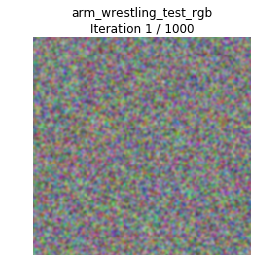

iteration: 199 65.2095308304


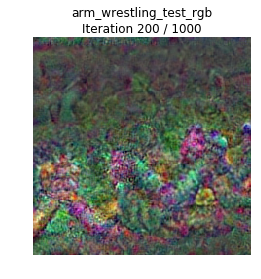

iteration: 399 125.502750874


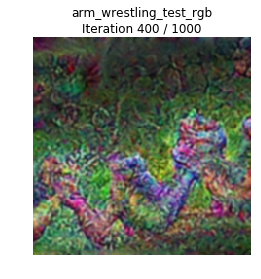

iteration: 599 188.177166939


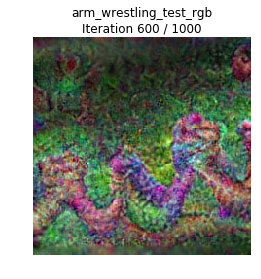

iteration: 799 251.906816959


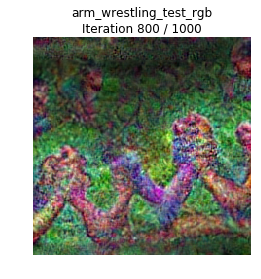

iteration: 999 317.698381901
file_name experiments_rgb/arm_wrestling_test/arm_wrestling_test_rgb{}.png


In [ ]:
"""
Run RGB visualization only
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # this line may vary depending on hardware
print(model_logits)
print(rgb_input)
target = 6 # change this to the desired class
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        # number of frames must be >= 9 or else kernel crashes due to gradient being too small
        rgb_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, rgb_logits, action_name + "_test", 
                                   stream_type='rgb', scale_every=1000, show_every=200)

The cell below is used to generate all Optical Flow Visualizations. The hyperparameters inputted below were the ones we found to be best, but we were unable to ever create any good Optical Flow results that were interpretable. 

In [ ]:
"""
Run FLOW visualization only.
Make sure graph is built in previous cell before running this cell
"""
os.environ["CUDA_VISIBLE_DEVICES"] = "0" # this line may vary depending on hardware
print(model_logits)
print(flow_input)
target = 171
print(kinetics_classes[target])
action_name = kinetics_classes[target].replace(" ", "_")
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        # THIS LINE NEEDS TO BE MOVED
        flow_saver.restore(sess, _CHECKPOINT_PATHS['flow_imagenet'])
        flow_visual_gif = create_class_visualization(sess, rgb_input, flow_input, target, flow_logits, 
                                                     action_name + "_test", stream_type='flow', num_frames=25, 
                                                     num_iterations=1000, l2_reg=1e-2, learning_rate=1.5, 
                                                     blur_every=10, max_jitter=32, sigma=.5, show_every=200)

In [7]:
"""
Displays all action classes so users can pick one they like.
"""
indexes = range(len(kinetics_classes))
class_to_index = dict(zip(kinetics_classes, indexes))
index_to_class = dict(zip(indexes, kinetics_classes))
print(index_to_class)


{0: 'abseiling', 1: 'air drumming', 2: 'answering questions', 3: 'applauding', 4: 'applying cream', 5: 'archery', 6: 'arm wrestling', 7: 'arranging flowers', 8: 'assembling computer', 9: 'auctioning', 10: 'baby waking up', 11: 'baking cookies', 12: 'balloon blowing', 13: 'bandaging', 14: 'barbequing', 15: 'bartending', 16: 'beatboxing', 17: 'bee keeping', 18: 'belly dancing', 19: 'bench pressing', 20: 'bending back', 21: 'bending metal', 22: 'biking through snow', 23: 'blasting sand', 24: 'blowing glass', 25: 'blowing leaves', 26: 'blowing nose', 27: 'blowing out candles', 28: 'bobsledding', 29: 'bookbinding', 30: 'bouncing on trampoline', 31: 'bowling', 32: 'braiding hair', 33: 'breading or breadcrumbing', 34: 'breakdancing', 35: 'brush painting', 36: 'brushing hair', 37: 'brushing teeth', 38: 'building cabinet', 39: 'building shed', 40: 'bungee jumping', 41: 'busking', 42: 'canoeing or kayaking', 43: 'capoeira', 44: 'carrying baby', 45: 'cartwheeling', 46: 'carving pumpkin', 47: 'cat

# Saleincy Maps Code
Below we now provide the code for creating the saliency maps. The code here currently produces a saleincy for the sample input provided by Deepmind. To create your own inputs, one will need to convert video clips into the .npy format. We suggest using skvideo (http://www.scikit-video.org/stable/io.html).

In [ ]:
"""
Compute saliency map
"""
print(model_logits)
print(rgb_input)
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        rgb_saver.restore(sess, _CHECKPOINT_PATHS['rgb_imagenet'])
        dX = tf.gradients(model_logits[0, sorted_indices[0]], rgb_input)
        absolute = tf.abs(dX)
        maxes = tf.reduce_max(absolute, axis=5)
        squeezed = tf.squeeze(maxes)
        # change rgb_input to compute new saliency map
        saliency = sess.run(squeezed, feed_dict={rgb_input:rgb_sample}) # this runs on sample cricket gif from i3d README

In [ ]:
"""
Create/Save saliency map in desired directory. Save indvidual frames to directory and then converts it to a GIF.

"""

directory = "./saliency/"

if not os.path.exists(directory):
        os.makedirs(directory)
name = directory + "cricket_saliency{}.png"
filenames = []
for i in range(79):
    plt.imshow(saliency[i], cmap=plt.cm.hot)
    # plt.show()
    filename = name.format(i)
    filenames.append(filename)
    plt.savefig(name.format(i))

import imageio
images = []
for filename in filenames:
    images.append(imageio.imread(filename))
imageio.mimsave('./saliency/cricket_saliency.gif', images)